In [1]:
import os
import yaml
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from types import SimpleNamespace
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import copy
import time
from PIL import Image
from zoneinfo import ZoneInfo
from datetime import datetime

In [2]:
project_root = "/data/ephemeral/home/upstageailab-cv-classification-cv_5"

import sys
sys.path.append(project_root)
from codes.gemini_utils import *
from codes.gemini_train import *
from codes.gemini_evalute import *
from codes.gemini_augmentation import *

submission_name = "2507041745-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img384-onaug_eda_dilation_erosion-clsaug_1-TTA_0-MP_0"

In [3]:
# model load
## 저장된 trainer를 로드하여 추론하는 경우 아래 함수로 로드
def load_checkpoint_model(savepath=None):
    if os.path.exists(savepath):
        checkpoint = torch.load(savepath)
        cfg = SimpleNamespace(**checkpoint['cfg'])
        model = get_timm_model(cfg)
        model.load_state_dict(checkpoint['model_state_dict'])
        return model, cfg
    else:
        raise ValueError("File does not exists!")
    
model, cfg = load_checkpoint_model(
    savepath=os.path.join(project_root, 'data', 'submissions', submission_name, f"{submission_name}.pth")
)

/tmp/ipykernel_443791/241282464.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(savepath)


In [4]:
### Data Load
df = pd.read_csv(os.path.join(cfg.data_dir, "train.csv"))
# Train-validation 분할
train_df, val_df = train_test_split(df, test_size=cfg.val_split_ratio, random_state=cfg.random_seed, stratify=df['target'] if cfg.stratify else None)

# 메타데이터 로드
meta = pd.read_csv(os.path.join(cfg.data_dir, 'meta.csv'))
meta_dict = zip(meta['target'], meta['class_name'])
meta_dict = dict(meta_dict)

train_transforms, val_transform, tta_transform = get_augmentation(cfg)
if cfg.online_augmentation:
    train_dataset = ImageDataset(train_df, os.path.join(cfg.data_dir, "train"), transform=train_transforms[0])
else:
    datasets = [ImageDataset(train_df, os.path.join(cfg.data_dir, "train"), transform=t) for t in train_transforms]
    train_dataset = ConcatDataset(datasets)

val_dataset = ImageDataset(val_df, os.path.join(cfg.data_dir, "train"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)
# For TTA, we need a loader with raw images
raw_transform = A.Compose([
    ToTensorV2()
])
val_dataset_raw = ImageDataset(val_df, os.path.join(cfg.data_dir, "train"), transform=raw_transform)
val_loader_raw = DataLoader(val_dataset_raw, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Running Normal Validation...


Prediction: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


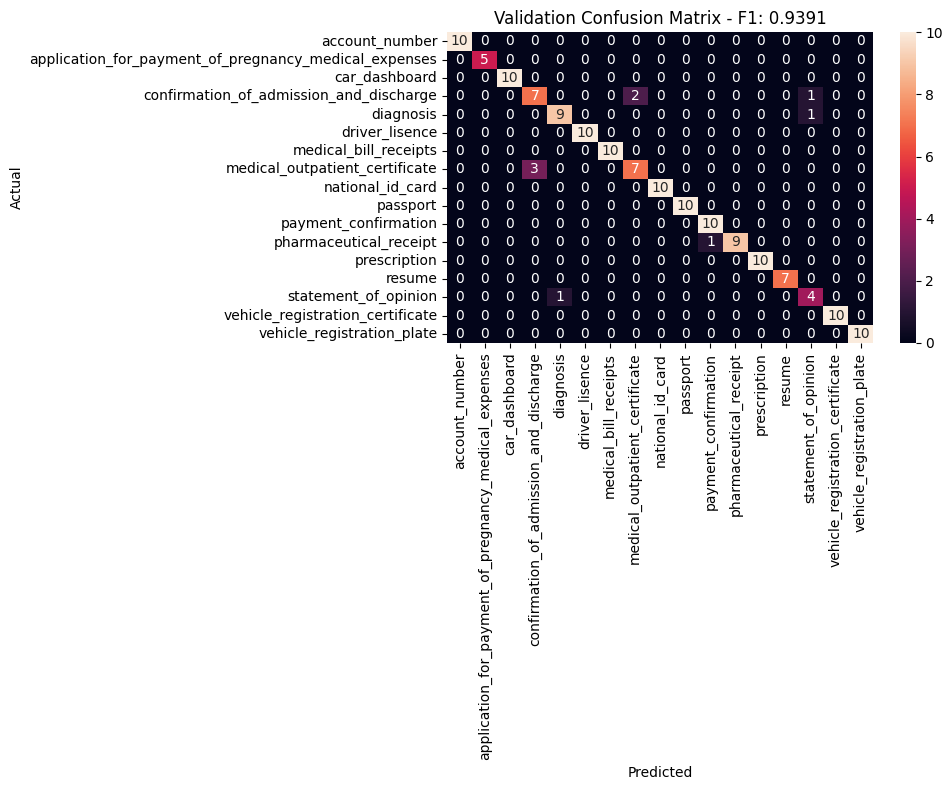

In [5]:
val_preds, val_f1 = do_validation(
    df=val_df, 
    model=model, 
    data=val_dataset_raw if cfg.TTA else val_loader, 
    transform_func=tta_transform, 
    cfg=cfg, 
    run=None, 
    show=True, 
    savepath=None
)

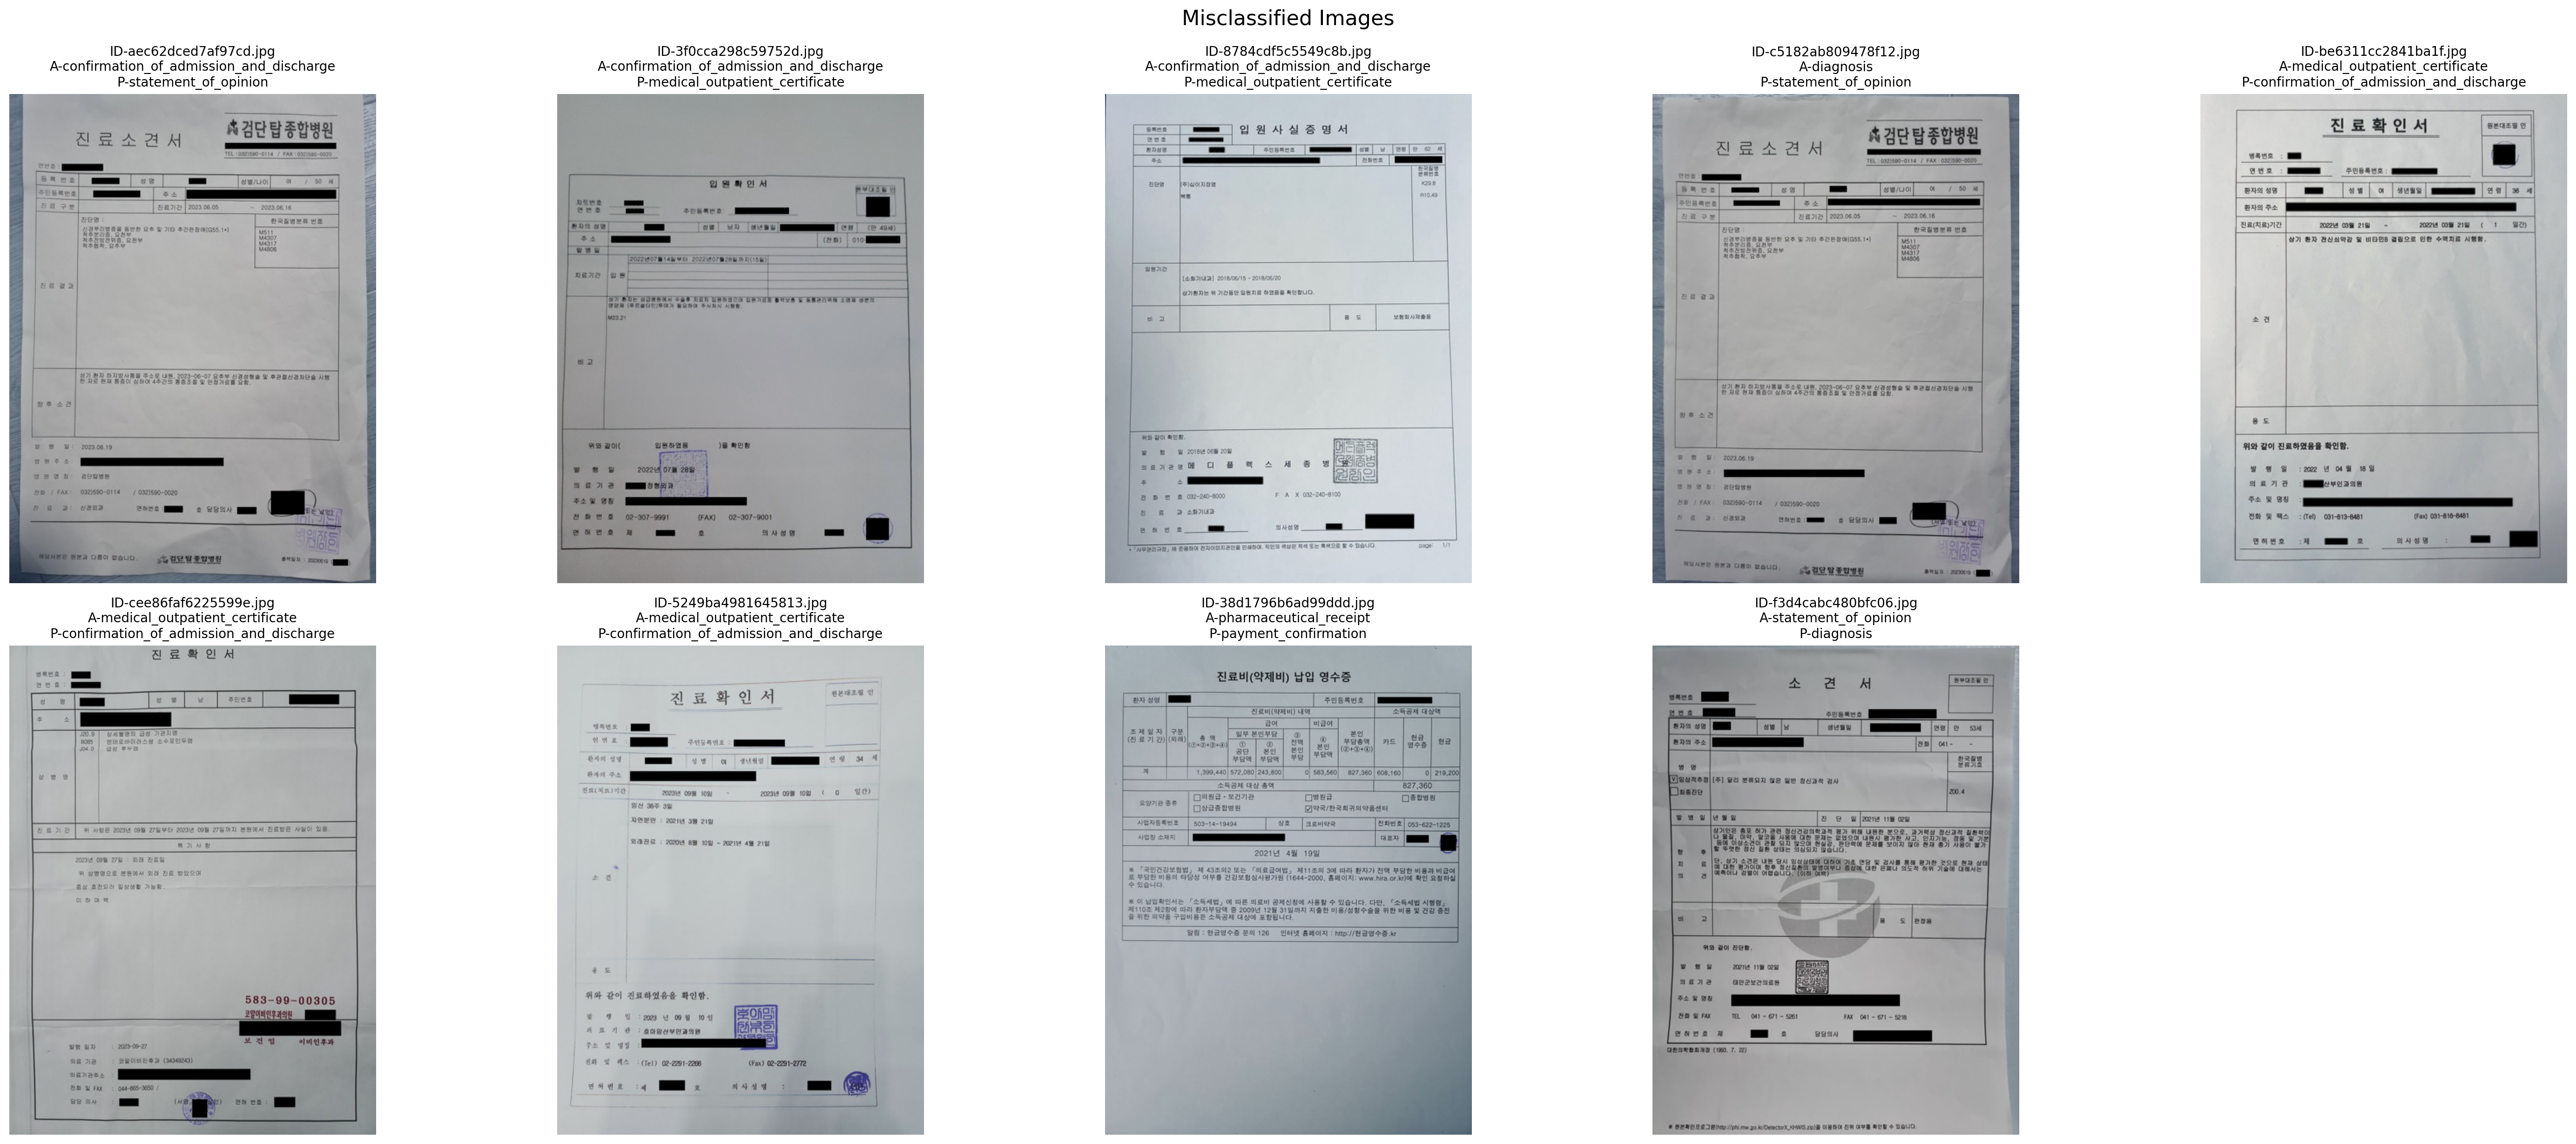

In [6]:
save_validation_images(
    val_df, val_preds,
    cfg, images_per_row=5, show=True
)